# Starbucks Capstone Project

### Introduction
The aim of sale promotions by companies on its products and services is to increase sales, attract new customers, encourage loyalty, and repeat purchases. These promotions usually have a lifespan and they are integrated accross various marketing channels. Inorder to run an effective and productive sales promotion, the company needs to collect and study its customers behaviour in relation to its product and services.

The customers wants to feel that the company truly undertands  them. The most important thing that makes a sales promotion productive is selecting the right target audience. By pretermining a target audience, companies can put their promotions to efficient use. This project aims to use Machine Learning to help Starbucks determine which demography of its customers will respond best to a certain type of promotion.


### Data
The dataset for this project contains simulated data that mimics customer behaviour on the Starbucks mobile reward app. This dataset is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. 

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The dataset contains transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

The data is contained in three files:
1. **profile**.json: Contains demographic data for each customer. It is made up of 17,000 customers with 5 fields.
    * gender: (categorical) M, F, O, or null.
    * age: (numeric) missing value encoded as 118.
    * id: (string/hash).
    * became_member_on: (date) format:YYYYMMDD.
    * income: (numeric).
2. **portfolio.json**: Contains data on offers sent during 30-day test period. It is made up of 10 offers with 6 fields.
    * reward: (numeric) money awarded for the amount spent.
    * channels: (list) web, email, mobile, social.
    * difficulty: (numeric) money required to be spent to receive reward.
    * duration: (numeric) time for offer to be open, in days.
    * offer_type: (string) bogo, discount, informational.
    * id: (string/hash).
3. **transcript.json**: Contains records for customer transactions, offers received, offers viewed, and offers completed. It is made up of 306648 transactions with 4 fields.
    * person: (string/hash).
    * event: (string) offer received, offer.
    * value: (dictionary) different values depending on event type:
        * offer id: (string/hash) not associated with any "transaction".
        * amount: (numeric) money spent in "transaction".
        * reward: (numeric) money gained from "offer completed".
    * time: (numeric) hours after start of test.

## Exploratory data analysis

The next stage of project data collection, visualization, preprocessing, and transformation.

### Data Collection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import matplotlib.pyplot as plt

In [15]:
# read from the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Analysis and Cleaning

#### 1. Portfolio dataset
Contains information about types of offers sent during a 30-days period

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


There are 10 rows of data and there are no null values in portfolio dataset. 

Next steps:
1. Convert the categorical columns values in portfolio dataset to numerical values using one hot encoding.
2. Change the name of the 'id' column to 'offer_id'.
3. Drop original categorical columns.

In [16]:
# One hot encoding 
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio = portfolio.join(portfolio.offer_type.str.get_dummies())
# Change column name
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
# Drop original categorical columns
portfolio.drop(['channels', 'offer_type'],axis=1,inplace=True)
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


#### 2. Profile dataset
Contains information demographic information about customers

In [17]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
# Check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 17,000 rows in profile dataset. Two columns in this dataset contain 2,175 null values each, the columns are 'gender' and 'became_member_on' columns. Lets view these rows with null values. Lets view what these rows with null values look like.


Text(0, 0.5, '')

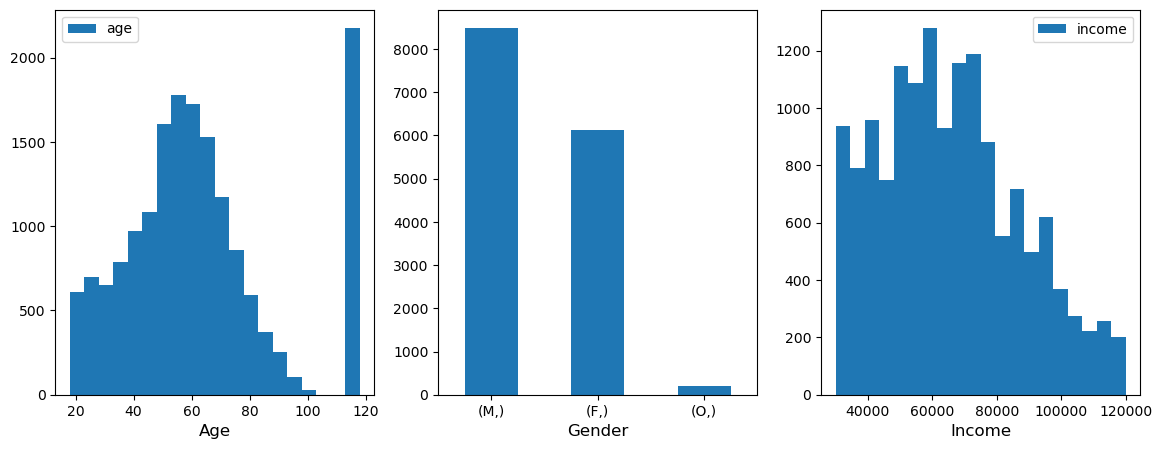

In [18]:
# profile dataset analysis
fig, ax = plt.subplots(1, 3, figsize=(14,5))

profile[['age']].plot(ax = ax[0],kind='hist', bins=20)
profile[['gender']].value_counts().plot(ax = ax[1], kind='bar', stacked=True, rot=0)
profile[['income']].plot(ax = ax[2], kind='hist', bins=20)

ax[0].set_xlabel('Age', fontsize=12)
ax[0].set_ylabel(None)
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel(None)
ax[2].set_xlabel('Income', fontsize=12)
ax[2].set_ylabel(None)

We can observe from the 'age' distribution that there is an outlier and that is from the maximum value in the age distribution. Let's view what this maximum age value is.

In [10]:
profile['age'].max()

118

In [11]:
# The outlier in 'age' distribution has a value of 118. Let's view rows where the value of age is 118.

profile[profile['age'] == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


It is observed that 'gender' column is null and 'income' column contain null values where 'age' is 118. In other words, the null values appear in both the columns for same rows. Its is advisable to drop these rows.

In [12]:
profile = profile[profile.age != 118]
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


C:\Users\EDIDIONG\AppData\Local\Temp\ipykernel_1780\1065850245.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(income_m, bins=30, label='Male',ax=ax)
C:\Users\EDIDIONG\AppData\Local\Temp\ipykernel_1780\1065850245.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(income_f, bins=30, label='F

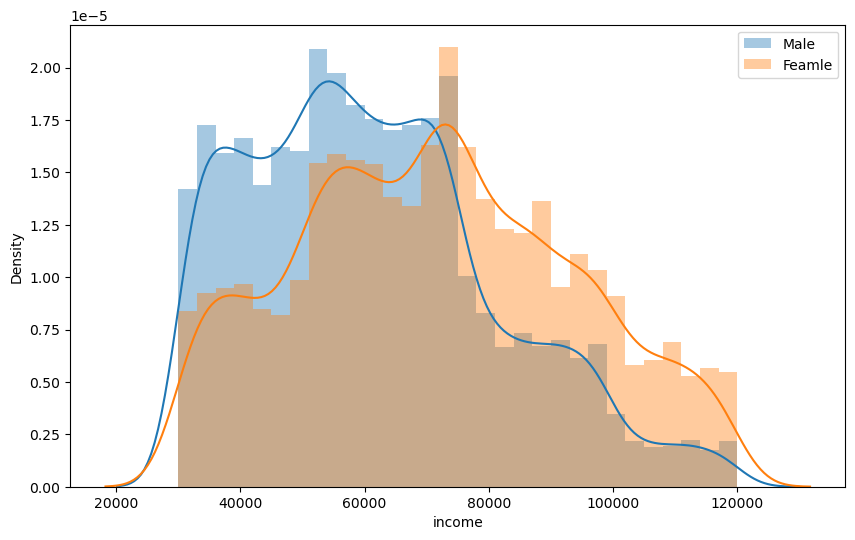

In [23]:
# Relationship between gender and income
income_m = profile[profile.gender == 'M'].income
income_f = profile[profile.gender == 'F'].income

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(income_m, bins=30, label='Male',ax=ax)
sns.distplot(income_f, bins=30, label='Feamle',ax=ax)
ax.legend()
plt.show()


C:\Users\EDIDIONG\AppData\Local\Temp\ipykernel_1780\3517019467.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(male_age, bins=30, label='Male',ax=ax)
C:\Users\EDIDIONG\AppData\Local\Temp\ipykernel_1780\3517019467.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(female_age, bins=30, label=

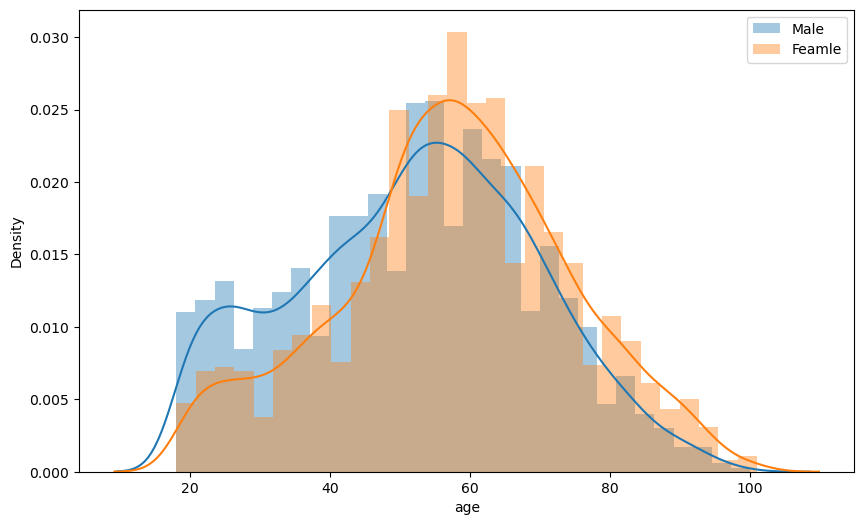

In [24]:
# Relationship between age and income
male_age = profile[profile.gender == 'M'].age
female_age = profile[profile.gender == 'F'].age

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(male_age, bins=30, label='Male',ax=ax)
sns.distplot(female_age, bins=30, label='Feamle',ax=ax)
ax.legend()
plt.show()